## Library

In [745]:
import os
import glob
import numpy as np
# from ccdproc import ImageFileCollection
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, hstack
from scipy.optimize import curve_fit

In [746]:
##	Plot presetting
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 500
plt.rc('font', family='serif')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 7DT

In [747]:
import sys
sys.path.append('..')
from util.helper import *
from util.sdtpy import *
register_custom_filters_on_speclite('../util')

Use `med25nm`, `med50nm`, `broad` as `group_name`


In [748]:
#	Subsequent filter info [AA]
bandmin=4000
bandmax=9000
bandwidth=250
bandstep=125
#	Maximum transmission of each filters
bandrsp=0.95
#	Wavelength bin [AA]
lammin=1000
lammax=10000
lamres=1000
#	Seeing Condition
seeing = 1.5
#
exptime = 180

D             : 50.5cm
D_obscuration : 29.8cm
Deff          : 40.770cm


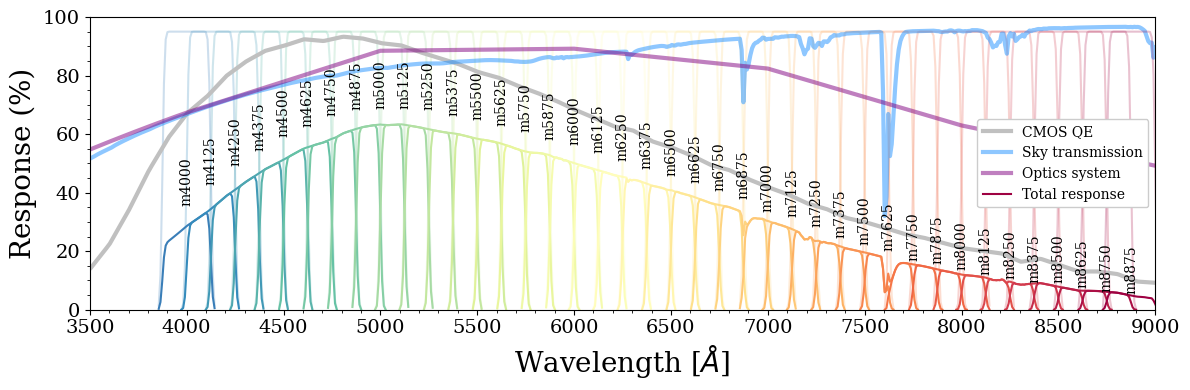

In [749]:
#	Exposure Time [s]
sdt = SevenDT()
sdt.echo_optics()
filterset = sdt.generate_filterset(bandmin=bandmin, bandmax=bandmax, bandwidth=bandwidth, bandstep=bandstep, bandrsp=bandrsp, lammin=lammin, lammax=lammax, lamres=lamres)
T_qe = sdt.get_CMOS_IMX455_QE()
sdt.get_optics()
s = sdt.get_sky()
sdt.smooth_sky()
totrsptbl = sdt.calculate_response()
Npix_ptsrc, Narcsec_ptsrc = sdt.get_phot_aperture(exptime=exptime, fwhm_seeing=seeing, optfactor=1.0, verbose=False)
outbl_ris = sdt.get_depth_table(Nsigma=5)
sdt.get_speclite()

## Initial Setting

In [750]:
field_table = Table.read('../conf/standard_field.csv')

for ii, obj in enumerate(field_table['obj']):
	if '-' not in obj:
		ground_tables = sorted(glob.glob(f"../data/Xshooter/*{obj.lower()}*")) + \
			sorted(glob.glob(f"../data/Xshooter/*{obj.upper()}*")) + \
			sorted(glob.glob(f"../data/SPSS/*{obj.lower()}*")) + \
			sorted(glob.glob(f"../data/SPSS/*{obj.upper()}*")) + \
			sorted(glob.glob(f"../data/CALSPEC/*{obj.lower()}*")) + \
			sorted(glob.glob(f"../data/CALSPEC/*{obj.upper()}*"))
	else:
		ground_tables = sorted(glob.glob(f"../data/Xshooter/*{obj.lower().replace('-', '_')}*")) + \
			sorted(glob.glob(f"../data/Xshooter/*{obj.upper().replace('-', '_')}*")) + \
			sorted(glob.glob(f"../data/SPSS/*{obj.lower().replace('-', '_')}*")) + \
			sorted(glob.glob(f"../data/SPSS/*{obj.upper().replace('-', '_')}*")) + \
			sorted(glob.glob(f"../data/CALSPEC/*{obj.lower().replace('-', '_')}*")) + \
			sorted(glob.glob(f"../data/CALSPEC/*{obj.upper().replace('-', '_')}*"))
	n_gtable = len(ground_tables)
	
	print(f"[{ii:0>3}] {obj}\t{n_gtable}")

[000] CD-34241	0
[001] EG21	1
[002] Feige110	3
[003] G114-25	0
[004] GJ2066	0
[005] GJ70	0
[006] HD199525	0
[007] HD209241	0
[008] HD270422	0
[009] HD270477	0
[010] HD271747	0
[011] HD271759	0
[012] HD271783	0
[013] HG7-15	0
[014] HILT600	1
[015] HIP28618	0
[016] LTT1020	1
[017] LTT1788	1
[018] LTT2415	1
[019] LTT3218	1
[020] LTT377	0
[021] LTT3864	1
[022] LTT4364	1
[023] LTT7987	2
[024] LTT9239	1
[025] LTT9491	1
[026] SDSS00832	0
[027] SDSS03532	0
[028] SDSS03932	0
[029] WD0046+051	0
[030] WD0047-524	0
[031] WD0050-332	0
[032] WD0104-331	0
[033] WD0106-358	0
[034] WD0109-264	0
[035] WD0123-262	0
[036] WD0227+050	0
[037] WD0316-849	0
[038] WD0435-088	0
[039] WD0446-789	0
[040] WD0455-282	0
[041] WD0501-289	0
[042] WD0552-041	0
[043] WD0604-203	0
[044] WD0621-376	0
[045] WD0646-253	0
[046] WD0721-276	0
[047] WD0749-383	0
[048] WD2039-682	1
[049] WD2105-820	0
[050] WD2115-560	0
[051] WD2152-548	0
[052] WD2211-495	0
[053] WD2216-657	0
[054] WD2309+105	0
[055] WD2331-475	0
[056] WD2359-434

In [751]:
nn = 22

obj = field_table['obj'][nn]

# obj = "LTT7987"
# obj = "HD270422"
# obj = "EG21"
radec = field_table['radec'][field_table['obj']==obj].item()
print(obj, radec)
# radec = '20 10 56.849 -30 13 06.63' # Wrong Position?
# radec = '20 10 56.2032 -30 13 12.656'
# date = '20231015'

# obj = "LTT9491"
# radec = '23 19 35.388 -17 05 28.47'
# date = '20231015'

LTT4364 11 45 42 -64 50 29


In [752]:
lam_min = 3750
lam_max = 9000

In [753]:
path_data = f"../data/7DT/{obj}"
# path_ground = f"../data/Xshooter/f{obj}.dat"
# path_ground = f"../data/SPSS/f{obj.lower()}.dat"
# path_ground = f"../data/CALSPEC/{obj.lower()}_002.fits"

In [754]:
if '-' not in obj:
	ground_tables = sorted(glob.glob(f"../data/Xshooter/*{obj.lower()}*")) + \
		sorted(glob.glob(f"../data/Xshooter/*{obj.upper()}*")) + \
		sorted(glob.glob(f"../data/SPSS/*{obj.lower()}*")) + \
		sorted(glob.glob(f"../data/SPSS/*{obj.upper()}*")) + \
		sorted(glob.glob(f"../data/CALSPEC/*{obj.lower()}*")) + \
		sorted(glob.glob(f"../data/CALSPEC/*{obj.upper()}*"))
else:
	ground_tables = sorted(glob.glob(f"../data/Xshooter/*{obj.lower().replace('-', '_')}*")) + \
		sorted(glob.glob(f"../data/Xshooter/*{obj.upper().replace('-', '_')}*")) + \
		sorted(glob.glob(f"../data/SPSS/*{obj.lower().replace('-', '_')}*")) + \
		sorted(glob.glob(f"../data/SPSS/*{obj.upper().replace('-', '_')}*")) + \
		sorted(glob.glob(f"../data/CALSPEC/*{obj.lower().replace('-', '_')}*")) + \
		sorted(glob.glob(f"../data/CALSPEC/*{obj.upper().replace('-', '_')}*"))


print(f"{len(ground_tables)} tables found")
for _tbl in ground_tables:
	print(_tbl)

path_ground = ground_tables[0]

1 tables found
../data/SPSS/fltt4364.dat


In [755]:
path_save = f"../output/comparison/{obj}"
if not os.path.exists(path_save):
	os.makedirs(path_save)

In [756]:
reftbl = Table.read(f"{path_data}/gaiaxp_dr3_synphot_{obj}.csv")

In [757]:
c = SkyCoord(radec, unit=(u.hourangle, u.deg))
c_ref = SkyCoord(reftbl['ra'], reftbl['dec'], unit="deg")

In [758]:
table = Table.read(f'{path_data}/summary.csv')
for nn, _cat in enumerate(table['cat']):
	newcat = f"{path_data}/{os.path.basename(_cat)}"
	if os.path.exists(newcat):
		table['cat'][nn] = newcat
	else:
		print(f"No data!")
table[:1]

file,simple,bitpix,naxis,naxis1,naxis2,extend,equinox,mjd-obs,radesys,ctype1,cunit1,crval1,crpix1,cd1_1,cd1_2,ctype2,cunit2,crval2,crpix2,cd2_1,cd2_2,exptime,gain,saturate,softname,softvers,softdate,softauth,softinst,author,origin,date,combinet,imagetyp,xbinning,ybinning,egain,xpixsz,ypixsz,instrume,set-temp,ccd-temp,telescop,focallen,focratio,ra,dec,pierside,siteelev,sitelat,sitelong,fwheel,filter,object,objctra,objctdec,objctrot,focname,focpos,focuspos,focussz,roworder,swcreate,resampt1,centert1,pscalet1,resampt2,centert2,pscalet2,date-obs,date-loc,exposure,centalt,centaz,airmass,mjd,jd,photime,seeing,peeing,ellip,elong,skysig,skyval,refcat,maglow,magup,stdnumb,auto,aper,aper_1,aper_2,aper_3,aper_4,aper_5,zp_auto,ezp_auto,ul3_auto,ul5_auto,zp_0,ezp_0,ul3_0,ul5_0,zp_1,ezp_1,ul3_1,ul5_1,zp_2,ezp_2,ul3_2,ul5_2,zp_3,ezp_3,ul3_3,ul5_3,zp_4,ezp_4,ul3_4,ul5_4,zp_5,ezp_5,ul3_5,ul5_5,comment,cat
str94,str4,int64,int64,int64,int64,str4,float64,float64,str4,str8,str3,float64,float64,float64,float64,str8,str3,float64,float64,float64,float64,int64,float64,float64,str5,str6,str10,str23,str22,str17,str16,str19,str6,str5,int64,int64,float64,float64,float64,str38,float64,float64,str5,float64,float64,float64,float64,str4,float64,float64,float64,str36,str4,str7,str8,str9,float64,str29,int64,int64,float64,str8,str25,str8,str6,str6,str8,str6,str6,str23,str26,int64,float64,float64,float64,float64,float64,str10,float64,float64,float64,float64,float64,float64,str6,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str63,str65
/large_data/processed/LTT4364/7DT01/g/calib_7DT01_LTT4364_20240103_065640_g_100.com.fits,True,-32,2,10200,6800,True,2000.0,60312.2875,ICRS,RA---TAN,deg,176.425,5100.5,-0.0001402777777778,0.0,DEC--TAN,deg,-64.84138888889,3400.5,0.0,0.0001402777777778,100,0.0,6412.645868738,SWarp,2.41.5,2023-10-20,2010-2012 IAP/CNRS/UPMC,IAP http://www.iap.fr,Gregory S.H. Paek,proton.snu.ac.kr,2024-01-05T14:37:57,MEDIAN,LIGHT,1,1,0.7799999713898,3.76,3.76,Moravian USB Camera,-10.0,-10.05225372314,7DT01,1537.0,3.0,176.4250027042,-64.8413950751,East,1600.0,-30.48647222222,-70.83855555556,Moravian USB Filter,g,LTT4364,11 45 42,-64 50 29,0.0,PlaneWave Focuser (v,7442,7442,1.0,TOP-DOWN,N.I.N.A. 2.2.0.9001,LANCZOS3,MANUAL,MANUAL,LANCZOS3,MANUAL,MANUAL,2024-01-03T06:56:40.284,2024-01-03T03:56:40.284000,100,47.33528127106181,155.864136253365,1.35877894258352,60312.28935513889,2460312.789355139,2024-01-06,2.242,4.44,0.076,1.082,0.242,0.006,GaiaXP,12.0,20.0,799,0.0,5.977,8.88,13.32,5.941,9.901,19.802,22.68,0.042,0.0,0.0,21.963,0.063,20.503,19.948,22.35,0.053,20.459,19.905,22.576,0.047,20.246,19.691,21.957,0.063,20.503,19.949,22.426,0.049,20.417,19.862,22.673,0.044,19.912,19.357,",,, Propagated FITS keywords,, Axis-dependent config parameters",../data/7DT/LTT4364/calib_7DT01_LTT4364_20240103_065640_g_100.com


- CALSPEC

In [759]:
if 'dat' in path_ground:
	fmt = 'ascii'
elif 'csv' in path_ground:
	fmt = 'csv'
elif 'fits' in path_ground:
	fmt = 'fits'

caltbl = Table.read(path_ground, format=fmt)
if 'SPSS' in path_ground:
	caltbl['col2'] /= 10**16

# if obj in ['LTT3218', 'LTT4364']:
# 	caltbl['col2'] /= 10**16

print(f"{len(caltbl)} rows table")

139 rows table


In [760]:
base_name, ext = os.path.splitext(path_ground)

col1,col2,col3,col4
float64,float64,float64,float64
3300.0,1.7067999999999999e-13,62.001,50.0
3350.0,1.7327e-13,64.863,50.0
3400.0,1.6961e-13,65.403,50.0
3450.0,1.6687e-13,66.252,50.0
3500.0,1.647e-13,67.298,50.0


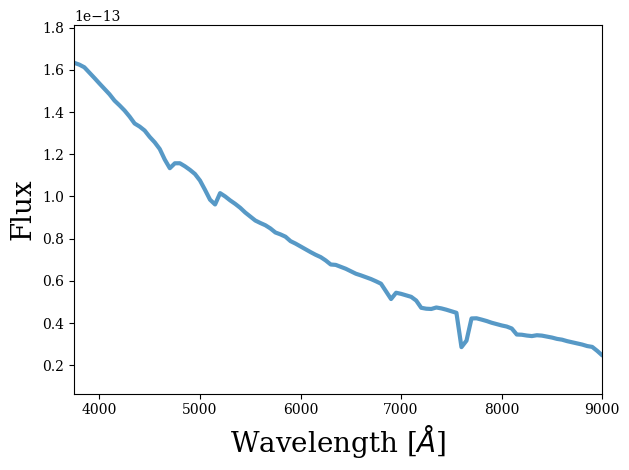

In [761]:
# caltbl.keys()
# plt.plot(caltbl['col1'], caltbl['col3'], lw=3, alpha=0.75)
# plt.plot(caltbl['WAVELENGTH'], caltbl['FLUX'], lw=3, alpha=0.75)
lamkey, flamkey = caltbl.keys()[0], caltbl.keys()[1]

plt.plot(caltbl[lamkey], caltbl[flamkey], lw=3, alpha=0.75)
plt.xlim(lam_min, lam_max)
plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel("Flux")
plt.tight_layout()
plt.savefig(f"{path_save}/{os.path.basename(path_ground).replace(ext, '.png')}")
caltbl[:5]

In [762]:
# caltbl['FLUX'].value*flamunit
fnu = convert_flam2fnu(caltbl[flamkey].value*flamunit, caltbl[lamkey].value*lamunit)
mag = fnu.to(u.ABmag)

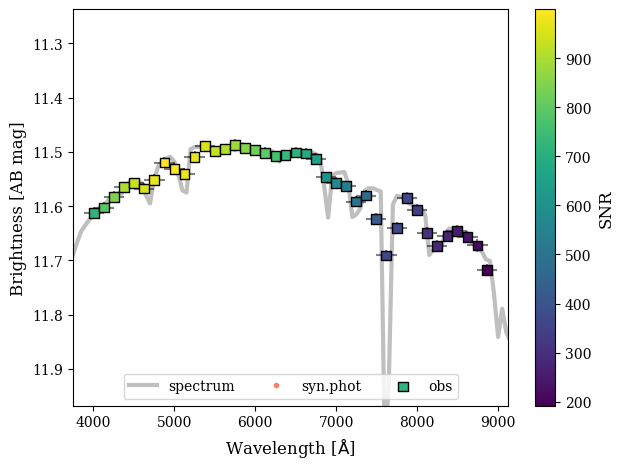

In [763]:
# flam_calspec, lam_calspec = caltbl['col2']*flamunit, caltbl['col1']*lamunit
flam_calspec, lam_calspec = caltbl[flamkey].value*flamunit, caltbl[lamkey].value*lamunit
mobstbl = sdt.get_synphot2obs(flam_calspec, lam_calspec, z=None, z0=None, figure=True)
mobstbl['filter'] = [filte[:-1] for filte in mobstbl['filter']]
plt.savefig(f"{path_save}/7dt_synphot.png")

## Comparison

In [764]:
basemagkey = 'MAG_AUTO'
basemagerrkey = 'MAGERR_AUTO'


In [765]:
mfilterlist = [filte for filte in np.unique(table['filter']) if 'm' in filte]
mfilterlist

['m400',
 'm425',
 'm450',
 'm475',
 'm500',
 'm525',
 'm575',
 'm600',
 'm625',
 'm650',
 'm675',
 'm700',
 'm725',
 'm750',
 'm775',
 'm800',
 'm850']

In [771]:
# filte = mfilterlist[0]

result_dict = {}

for filte in mfilterlist:

	magkey = f"{basemagkey}_{filte}"
	magerrkey = f"{basemagerrkey}_{filte}"

	_table = table[table['filter']==filte]
	nn = 0
	# incat = _table['cat'][nn]
	inim = _table['file'][nn]
	incat = f"../data/7DT/{obj}/{os.path.basename(inim).replace('fits', 'phot.cat')}"
	# filte = _table['filter'][nn]
	airmass = _table['airmass'][nn]
	intbl = Table.read(incat, format='ascii')
	c_cat = SkyCoord(intbl['ALPHA_J2000'], intbl['DELTA_J2000'], unit="deg")
	##	Matching
	indx_in, sep_in, _ = c.match_to_catalog_sky(c_cat)
	indx_ref, sep_ref, _ = c.match_to_catalog_sky(c_ref)

	mag_calspec = mobstbl['magapp'][mobstbl['filter']==filte].item()
	mag_7dt = intbl[magkey][indx_in]
	magerr_7dt = intbl[magerrkey][indx_in]
	mag_gaia = reftbl[f"{filte}_mag"][indx_ref]

	print('seperation', sep_in.arcsec, sep_ref.arcsec)
	# print('7DT:', mag_7dt, '+/-', magerr_7dt)
	# print('Gaia:', mag_gaia)
	# print('CALSPEC:', mag_calspec)

	result_dict[filte] = {
		'7DT': {
			'mag': mag_7dt,
			'magerr': magerr_7dt
		},
		'Gaia': {
			'mag': mag_gaia,
		},
		'CALSPEC': {
			'mag': mag_calspec,
		},
	}

seperation [39.47628596] [48.80117186]
seperation [27.5834226] [48.80117186]
seperation [22.01388304] [48.80117186]
seperation [17.16809057] [48.80117186]
seperation [14.69133826] [48.80117186]
seperation [14.69757924] [48.80117186]
seperation [14.76297106] [48.80117186]
seperation [14.7222007] [48.80117186]
seperation [14.56159806] [48.80117186]
seperation [14.7641489] [48.80117186]
seperation [14.73791552] [48.80117186]
seperation [14.73374894] [48.80117186]
seperation [14.67815205] [48.80117186]
seperation [14.66964499] [48.80117186]
seperation [14.69650156] [48.80117186]
seperation [14.74830631] [48.80117186]
seperation [14.78797026] [48.80117186]


In [767]:
# 각 파장 및 관측소별 데이터를 저장할 리스트 초기화
wavelengths = []
mag_7DT = []
magerr_7DT = []
mag_Gaia = []
mag_CALSPEC = []

# 사전 데이터를 반복하여 리스트에 값 추가
for wave, data in result_dict.items():
    wavelengths.append(wave)
    mag_7DT.append(data['7DT'].get('mag', None))
    magerr_7DT.append(data['7DT'].get('magerr', None))
    mag_Gaia.append(data['Gaia'].get('mag', None))
    mag_CALSPEC.append(data['CALSPEC'].get('mag', None))

# Astropy 테이블 생성
outbl = Table([wavelengths, mag_7DT, magerr_7DT, mag_Gaia, mag_CALSPEC], 
              names=('Wavelength', '7DT Mag', '7DT MagErr', 'Gaia Mag', 'CALSPEC Mag'))

outbl.write(f"{path_save}/output.csv", format='csv', overwrite=True)
print(outbl)

Wavelength 7DT Mag 7DT MagErr      Gaia Mag         CALSPEC Mag    
---------- ------- ---------- ------------------ ------------------
      m400  17.561      0.083  11.60989483529756 11.615369020171407
      m425  17.873      0.081 11.565778589505335 11.582347685328479
      m450  18.137      0.072 11.523837088619167 11.558696915862583
      m475   18.36      0.084 11.511257567115344 11.550083910369038
      m500  18.521      0.086 11.503904559038368 11.531380486933763
      m525  18.254      0.092 11.479600406364845 11.509078405824155
      m575  17.475       0.06 11.470136739493462 11.489413093686789
      m600  17.331      0.058  11.47191980634586 11.496695061545665
      m625  16.961      0.053 11.469488917800582 11.505350098896248
      m650  16.865      0.056 11.489870511932942 11.503256659654857
      m675  16.616      0.039  11.50582582791953 11.513804766110356
      m700  16.523      0.055 11.520850174164558 11.555018254823239
      m725  16.088      0.046 11.544692531949359

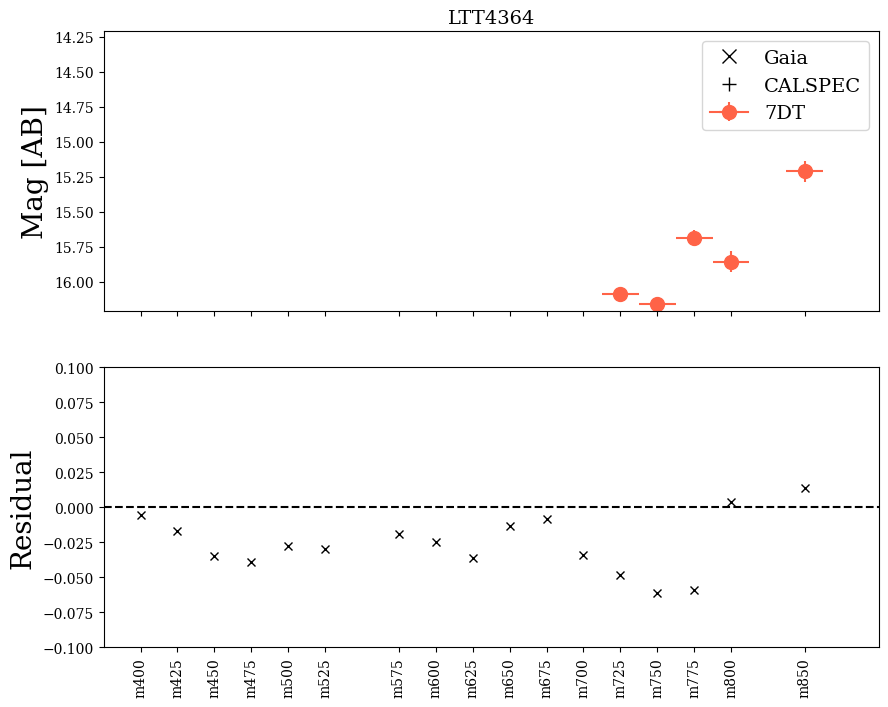

In [768]:
filterticks = [filte for filte in list(result_dict.keys())]
# filterticks
lamarr = [int(filte[1:]) for filte in filterticks]
# fig = plt.figure(figsize=(10, 4))

# 그래프와 잔차 플롯을 위한 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# 기존 그래프
ax1.plot(lam_calspec/10., mag, color='grey', lw=3, alpha=0.75, zorder=0)

# plt.plot(lam_calspec/10., mag, color='grey', lw=3, alpha=0.75, zorder=0,)
ax1.plot(lam_calspec/10., mag, color='grey', lw=3, alpha=0.75, zorder=0,)

for ff, filte in enumerate(filterticks):
	#	7DT
	mag_7dt = result_dict[filte]['7DT']['mag']
	magerr_7dt = result_dict[filte]['7DT']['magerr']
	#	Gaia
	mag_gaia = result_dict[filte]['Gaia']['mag']
	#	CALSPEC
	mag_calspec = result_dict[filte]['CALSPEC']['mag']

	#
	lam = lamarr[ff]
	if ff == 0:
		ax1.errorbar([lam], [mag_7dt], xerr=[12.5], yerr=[magerr_7dt], color='tomato', marker='o', label='7DT', ms=10)
		ax1.plot([lam], [mag_gaia], 'x', color='k', zorder=999, label='Gaia', ms=10)
		ax1.plot([lam], [mag_calspec], '+', color='k', zorder=999, label='CALSPEC', ms=10)
	else:
		ax1.errorbar([lam], [mag_7dt], xerr=[12.5], yerr=[magerr_7dt], color='tomato', marker='o', ms=10)
		ax1.plot([lam], [mag_gaia], 'x', color='k', zorder=999, ms=10)
		ax1.plot([lam], [mag_calspec], '+', color='k', zorder=999, ms=10)


# yl, yu = plt.ylim()
yu = mag_7dt+1.0
yl = mag_7dt-1.0
ax1.set_ylim([yu, yl])
ax1.set_xlim([lam_min/10, lam_max/10])
ax1.set_ylabel('Mag [AB]')
# _ = plt.xticks(lamarr, filterticks, rotation=90)
ax1.set_title(f"{obj}")
ax1.legend(loc='upper right', fontsize=14)
# plt.tight_layout()

# 잔차 플롯
residuals_7dt = []
residuals_gaia = []
residuals_calspec = []
for ff, filte in enumerate(filterticks):
    mag_7dt = result_dict[filte]['7DT']['mag']
    mag_gaia = result_dict[filte]['Gaia']['mag']
    mag_calspec = result_dict[filte]['CALSPEC']['mag']
    lam = lamarr[ff]

	#	7DT
    residual_7dt = mag_7dt - mag_calspec
    residuals_7dt.append(residual_7dt)
    ax2.plot([lam], [residual_7dt], 'o', color='tomato')

	#	Gaia
    residual_gaia = mag_gaia - mag_calspec
    residuals_gaia.append(residual_gaia)
    ax2.plot([lam], [residual_gaia], 'x', color='k')

	#	CALSPEC
    # residual_calspec = mag_gaia - mag_calspec
    # residuals_gaia.append(residual_gaia)
    # ax2.plot([lam], [residual_gaia], 'x', color='k')

ax2.axhline(0, color='k', linestyle='--')  # 잔차가 0인 선 추가

# 축 설정
ax2.set_xlim([lam_min/10, lam_max/10])
ax2.set_ylim([-0.1, +0.1])
ax2.set_ylabel('Residual')
_ = ax2.set_xticks(lamarr)
_ = ax2.set_xticklabels(filterticks, rotation=90)

plt.savefig(f"{path_save}/result_comp.png")


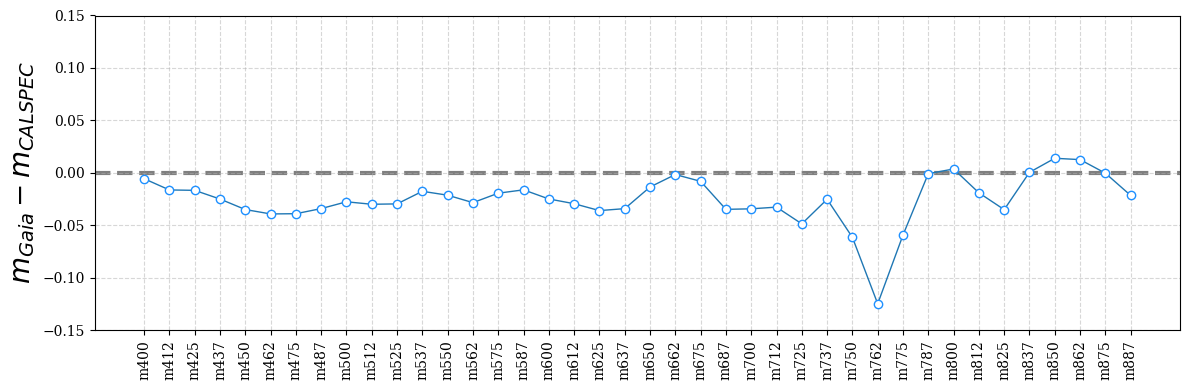

In [769]:
xarr = np.arange(len(mobstbl['filter']))

fig = plt.figure(figsize=(12, 4))

delmaglist = []
for filte in mobstbl['filter']:
	mag_calspec = mobstbl['magapp'][mobstbl['filter']==filte].item()
	mag_gaia = reftbl[f"{filte}_mag"][indx_ref]

	delmag = mag_gaia - mag_calspec
	delmaglist.append(delmag)

plt.axhline(y=0, ls='--', lw=3, alpha=0.5, zorder=0, color='k')
plt.plot(xarr, delmaglist, 'o-', mfc='w', mec='dodgerblue', lw=1)
plt.ylabel(r"$m_{Gaia}-m_{CALSPEC}$")
plt.ylim(-0.15, 0.15)
_ = plt.xticks(xarr, mobstbl['filter'], rotation=90)
plt.grid('both', ls='--', alpha=0.5)
plt.tight_layout()

plt.savefig(f"{path_save}/comp_gaia_calspec.png",)

In [770]:
Table(reftbl[indx_ref]).write(f"{path_save}/gaia.csv", format='csv', overwrite=True)